<a href="https://colab.research.google.com/github/hkaragah/google_colab_repo/blob/main/hands_on_ml_exercises/05_svm_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonlinear SVM Classifier

__Disclaimer:__ This exercise is adopted from `"Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow (Third Edition)"` book written by `_Aurelien Geron_` publoshed by `_O'Reilly_`. I broke them down into smaller digestable snippets, made some modifications, and added some explanations so that I can undersatand them better. The porpuse of this notebook is just for me to understand the concept and have hands-on practice while reading the book material.

## Objective
Explore nonlinear classifer provided by __Scikit Learn__ library

## Import  Data
For this exercise, I import `make_moons` dataset from `sklearn` which requires a nonlinear decision boundary. Let's import the necessary libraries and the datasets.

In [7]:
from sklearn.datasets import make_moons
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVC, SVC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

To show how the `noise` parameter of the data works, I am going to create two datsets, with and without noise.

In [3]:
X, y = make_moons(n_samples=100, shuffle=True, noise=0.15, random_state=42)
X1, y1 = make_moons(n_samples=100, shuffle=True, noise=0.0, random_state=42)

## Inspect Data

In [ ]:
print(X.shape, y.shape)
print(X[:5], y[:5])

(100, 2) (100,)
[[ 1.61383833 -0.49115086]
 [ 0.08984723  0.50439056]
 [ 0.74721047 -0.36911116]
 [-1.10174514  0.23685641]
 [-0.72871455  0.14652347]] [1 1 1 0 0]


## Plot Data

In [4]:
def decorate(ax, title=''):
    ax.set_title(title)
    ax.set_xlabel("x1", fontsize=10)
    ax.set_ylabel("x2", fontsize=10)
    ax.grid()

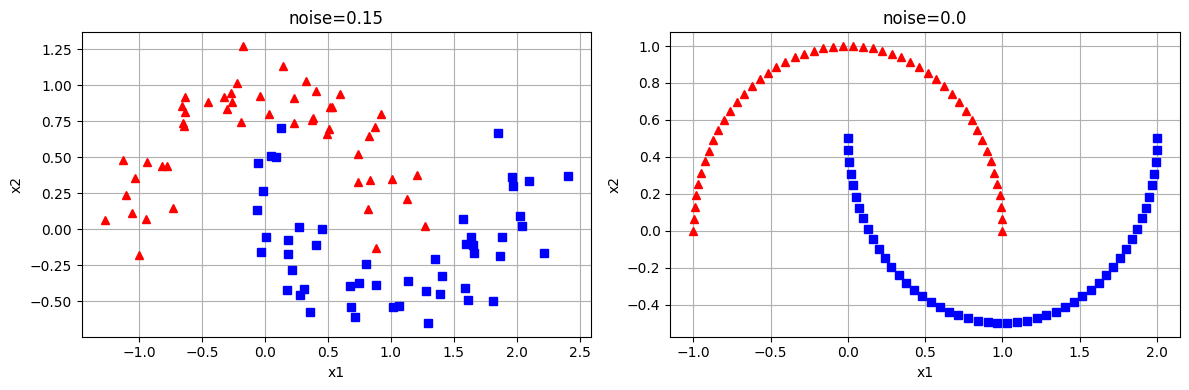

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))  # 1 row, 2 columns

# Plot on the left subplot (svm_clf1 with C=1)
ax1.plot(X[:, 0][y==0], X[:, 1][y==0], "r^")
ax1.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
decorate(ax1, title="noise=0.15")


# Plot on the second subplot
ax2.plot(X1[:, 0][y1==0], X1[:, 1][y1==0], "r^")
ax2.plot(X1[:, 0][y1==1], X1[:, 1][y1==1], "bs")
decorate(ax2, title="noise=0.0")

plt.tight_layout()
plt.show()

As shown, the data on the right is composed of two perfect half-circles. For the porpuse of this exercise, we not going to use it.

## Training SVC classifier
I will train 4 clasifiers:

- LinearSVC with using 3rd degree polynomial features (`moons_svm_clf_poly`)
- SVC with kernel='poly', degree=3, C=10, coef0=1 (`moon_svm_clf_c10_cf1`)
- SVC with kernel='poly', degree=3, C=10, coef0=100 (`moon_svm_clf_c10_cf100`)
- SVC with kernel='poly', degree=3, C=100, coef0=1 (`moon_svm_clf_c100_cf1`)

The hyperparameter __coef0__ has a regulazition effect and increasing it make the model more controled by the high-degree terms rather than low-degree terms.

In [8]:
moons_svm_clf_kernel_c10cf1 = make_pipeline(
    StandardScaler(),
    SVC(C=10, kernel='poly', degree=3, coef0=1, random_state=42)
)

moons_svm_clf_poly = make_pipeline(
    PolynomialFeatures(degree=3),
    StandardScaler(),
    LinearSVC(C=10, max_iter=10_000, dual=True, random_state=42)
)

moons_svm_clf_kernel_c10cf100 = make_pipeline(
    StandardScaler(),
    SVC(C=10, kernel='poly', degree=3, coef0=100, random_state=42)
)

moons_svm_clf_kernel_c100cf1 = make_pipeline(
    StandardScaler(),
    SVC(C=100, kernel='poly', degree=3, coef0=1, random_state=42)
)

moons_svm_clf_kernel_c10cf1.fit(X, y)
moons_svm_clf_poly.fit(X, y)
moons_svm_clf_kernel_c10cf100.fit(X, y)
moons_svm_clf_kernel_c100cf1.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100, coef0=1, kernel='poly', random_state=42))])

## Plot Models
Now, let's plot the models and compare them. But, first we need to define some helper function to do the repetitive tasks for us.

In [10]:
def generate_meshgrid(x_limits, n):
    x0_min, x0_max = x_limits[0]
    x1_min, x1_max = x_limits[1]
    x0_vec = np.linspace(x0_min, x0_max, n) # shape (100,)
    x1_vec = np.linspace(x1_min, x1_max, n) # shape (100,)
    x0, x1 = np.meshgrid(x0_vec, x1_vec) # shape of x0 and x1 (100, 100)
    x = np.c_[x0.ravel(), x1.ravel()] # shape of x (10_000, 2), shape of x0.ravel() and x1.ravel() (10_000,)
    return x0, x1, x

def make_predictions(clf, x):
    # shape of x (n**2, 2) for 2D space (2 features)
    y_pred = clf.predict(x) # shape (n**2,), this defines the boundary curve (true/flase)
    y_decision = clf.decision_function(x) # shape (n**2,), this defines the contour curves
    return y_pred, y_decision

def plot_predictions(clf, x_limits, n, ax):
    x0, x1, x = generate_meshgrid(x_limits, n)
    y_pred, y_decision = make_predictions(clf, x)
    ax.contourf(x0, x1, y_pred.reshape(x0.shape), cmap=plt.cm.coolwarm, alpha=0.3) # Defines the boundary curve
    ax.contourf(x0, x1, y_decision.reshape(x0.shape), cmap=plt.cm.coolwarm, alpha=0.2) # Defines the contour curves

def plot_datapoints(X, y, ax, title=''):
    ax.plot(X[:, 0][y==0], X[:, 1][y==0], "r^")
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.grid()

There are several methods to create the subplots.
### Method 1:

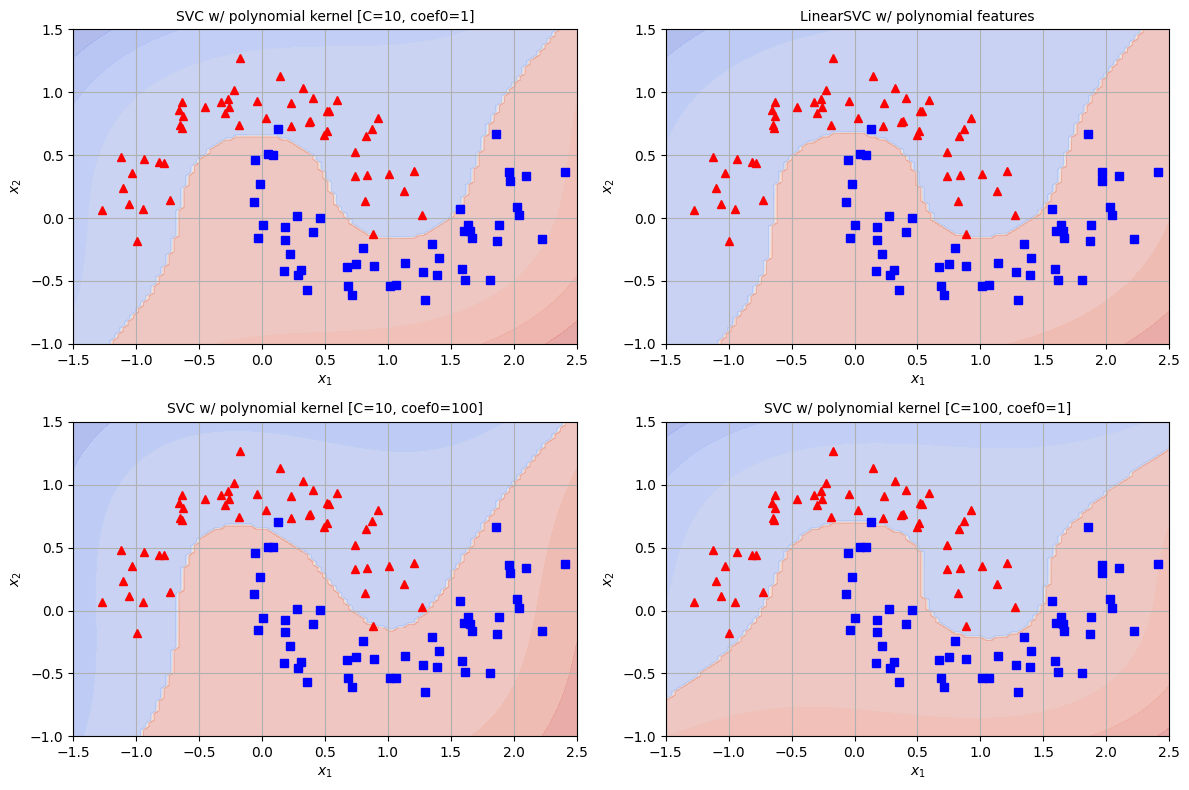

In [11]:
x_limits = [(-1.5, 2.5), (-1, 1.5)]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))  # 1 row, 2 columns

plot_datapoints(X, y, axes[0,0], title='SVC w/ polynomial kernel [C=10, coef0=1]')
plot_predictions(moons_svm_clf_kernel_c10cf1, x_limits, 100, axes[0,0])

plot_datapoints(X, y, axes[0,1], title='LinearSVC w/ polynomial features')
plot_predictions(moons_svm_clf_poly, x_limits, 100, axes[0,1])

plot_datapoints(X, y, axes[1,0], title='SVC w/ polynomial kernel [C=10, coef0=100]')
plot_predictions(moons_svm_clf_kernel_c10cf100, x_limits, 100, axes[1,0])

plot_datapoints(X, y, axes[1,1], title='SVC w/ polynomial kernel [C=100, coef0=1]')
plot_predictions(moons_svm_clf_kernel_c100cf1, x_limits, 100, axes[1,1])

plt.tight_layout()
plt.show()

## Method 2

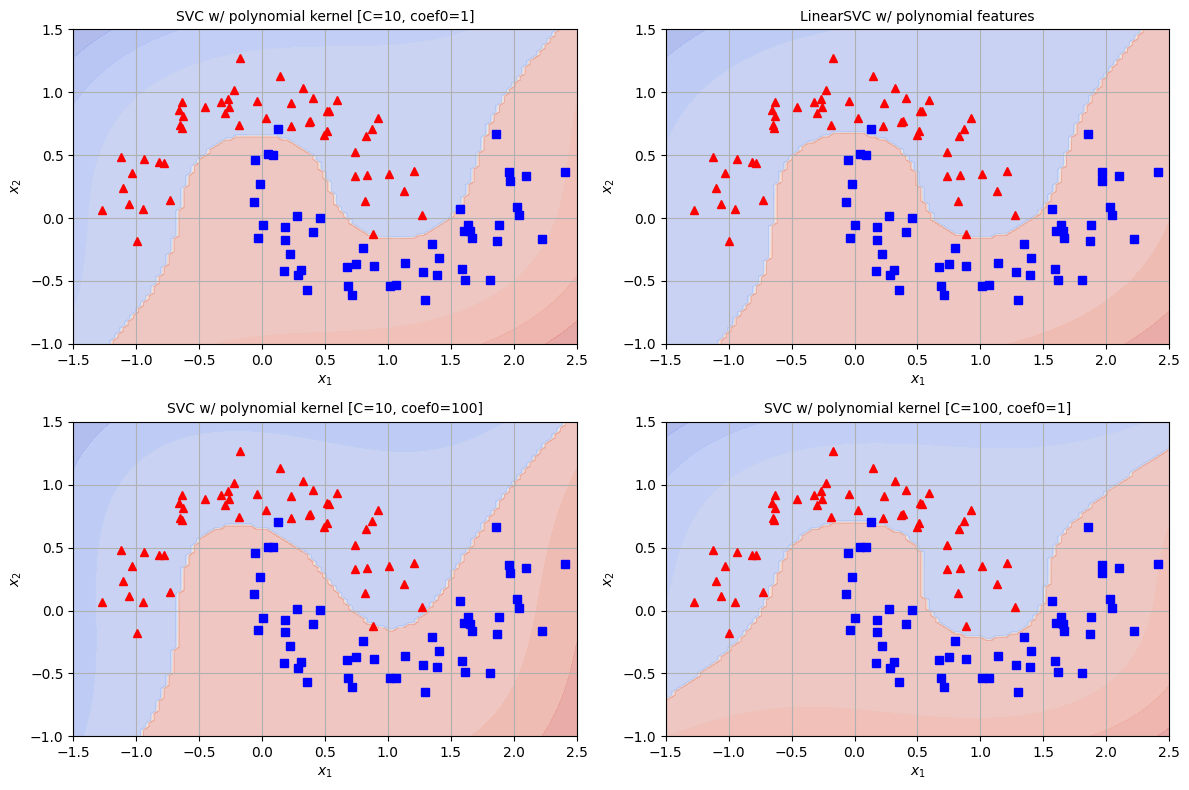

In [12]:
# Another method to create the subplots is to use 'plt.subplot' instead of 'plt.subplots'
import matplotlib.pyplot as plt

x_limits = [(-1.5, 2.5), (-1, 1.5)]

fig = plt.figure(figsize=(12, 8))

ax1 = plt.subplot(221)  # 2 rows, 2 columns, subplot 1
plot_datapoints(X, y, ax1, title='SVC w/ polynomial kernel [C=10, coef0=1]')
plot_predictions(moons_svm_clf_kernel_c10cf1, x_limits, 100, ax1)

ax2 = plt.subplot(222)  # 2 rows, 2 columns, subplot 2
plot_datapoints(X, y, ax2, title='LinearSVC w/ polynomial features')
plot_predictions(moons_svm_clf_poly, x_limits, 100, ax2)

ax3 = plt.subplot(223)  # 2 rows, 2 columns, subplot 3
plot_datapoints(X, y, ax3, title='SVC w/ polynomial kernel [C=10, coef0=100]')
plot_predictions(moons_svm_clf_kernel_c10cf100, x_limits, 100, ax3)

ax4 = plt.subplot(224)  # 2 rows, 2 columns, subplot 4
plot_datapoints(X, y, ax4, title='SVC w/ polynomial kernel [C=100, coef0=1]')
plot_predictions(moons_svm_clf_kernel_c100cf1, x_limits, 100, ax4)

plt.tight_layout()
plt.show()

## Method 3:

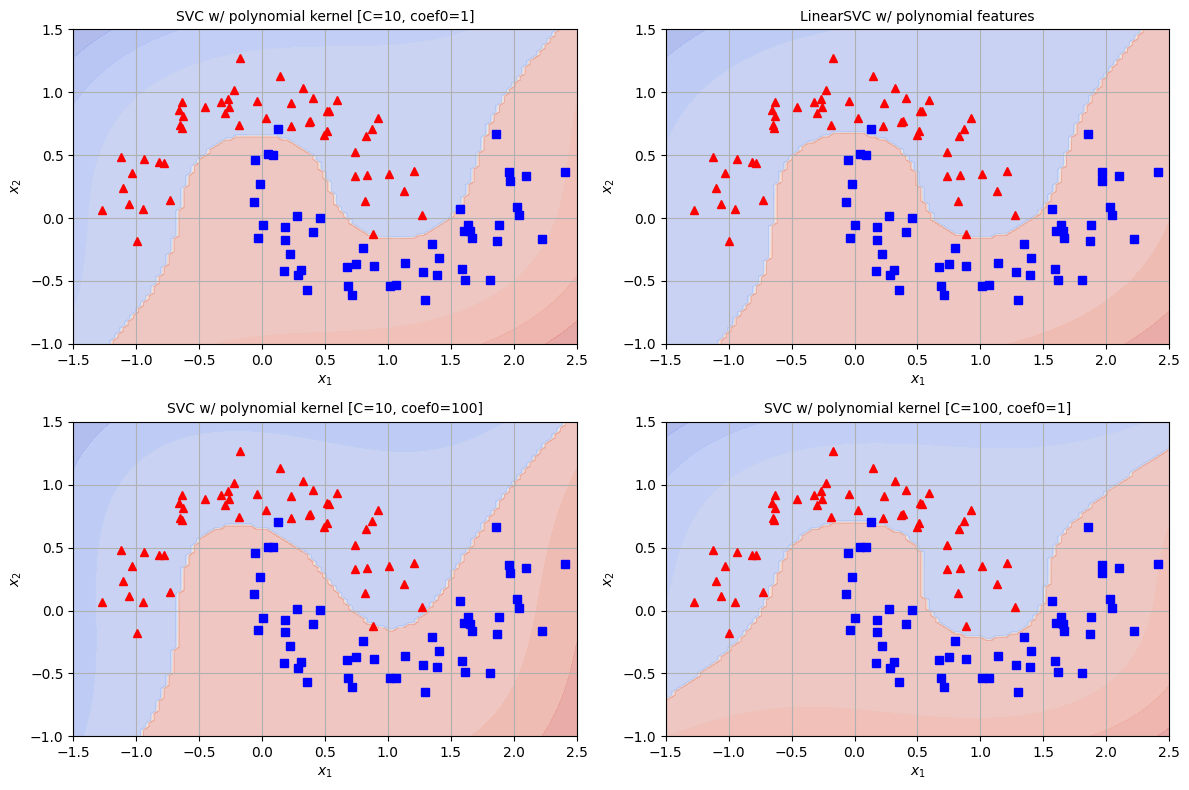

In [13]:
 # Another method is using loop
x_limits = [(-1.5, 2.5), (-1, 1.5)]

titles = [
    'SVC w/ polynomial kernel [C=10, coef0=1]',
    'LinearSVC w/ polynomial features',
    'SVC w/ polynomial kernel [C=10, coef0=100]',
    'SVC w/ polynomial kernel [C=100, coef0=1]'
]

clfs = [
    moons_svm_clf_kernel_c10cf1,
    moons_svm_clf_poly,
    moons_svm_clf_kernel_c10cf100,
    moons_svm_clf_kernel_c100cf1
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.ravel()  # Flatten the 2x2 array of axes for easier indexing

for ax, clf, title in zip(axes, clfs, titles):
    plot_datapoints(X, y, ax, title=title)
    plot_predictions(clf, x_limits, 100, ax)

plt.tight_layout()
plt.show()

## Method 4:

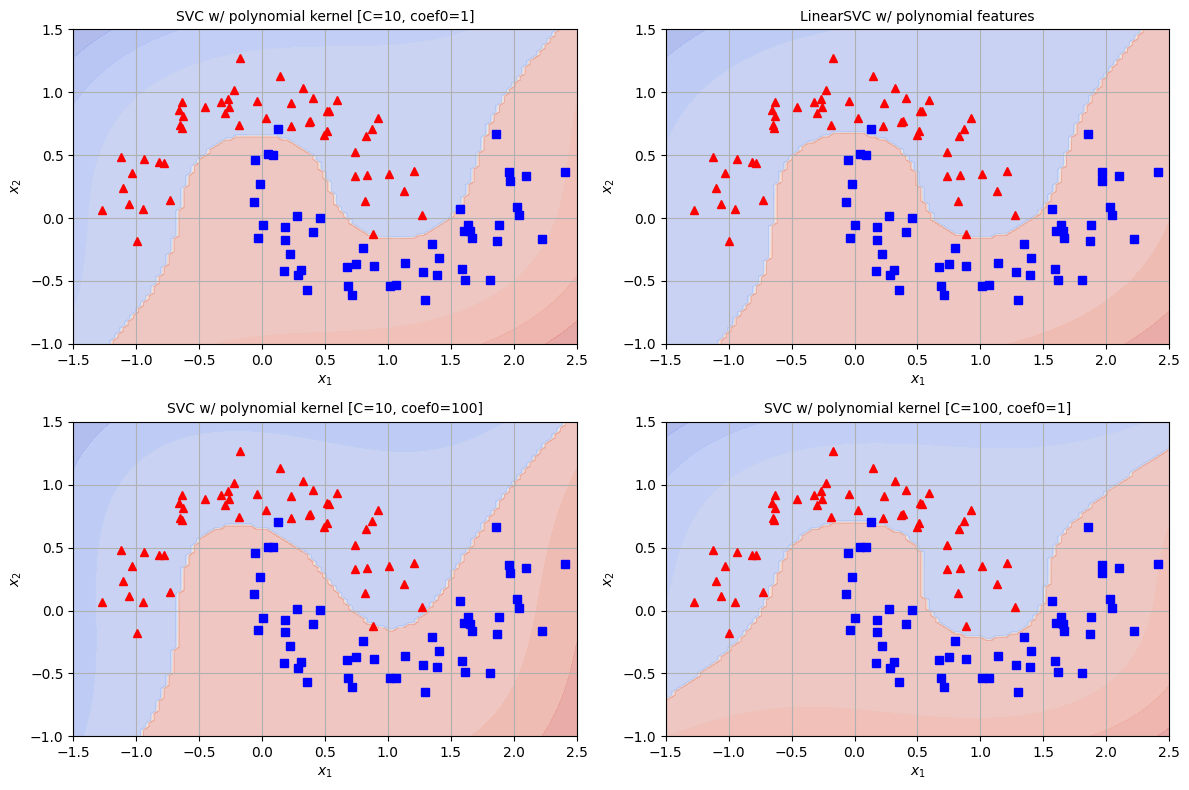

In [14]:
# Last method is to use gridspec
import matplotlib.gridspec as gridspec

x_limits = [(-1.5, 2.5), (-1, 1.5)]

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
plot_datapoints(X, y, ax1, title='SVC w/ polynomial kernel [C=10, coef0=1]')
plot_predictions(moons_svm_clf_kernel_c10cf1, x_limits, 100, ax1)

ax2 = fig.add_subplot(gs[0, 1])
plot_datapoints(X, y, ax2, title='LinearSVC w/ polynomial features')
plot_predictions(moons_svm_clf_poly, x_limits, 100, ax2)

ax3 = fig.add_subplot(gs[1, 0])
plot_datapoints(X, y, ax3, title='SVC w/ polynomial kernel [C=10, coef0=100]')
plot_predictions(moons_svm_clf_kernel_c10cf100, x_limits, 100, ax3)

ax4 = fig.add_subplot(gs[1, 1])
plot_datapoints(X, y, ax4, title='SVC w/ polynomial kernel [C=100, coef0=1]')
plot_predictions(moons_svm_clf_kernel_c100cf1, x_limits, 100, ax4)

plt.tight_layout()
plt.show()


Now that I have the plots ready, let's see what we got.<br>

The classifier with `C=100` and `coef0=1` perfroms the best in classifying the training dataset, however, it might suffer from __overfitting__. On the other hand, the classifier with `C=10` and `coef0=100` seems to perform worse than the one with `C=10` and `coef0=1`.